Import the required libraries

In [1]:
from d3rlpy.datasets import get_cartpole
from d3rlpy.algos import DiscreteCQL, DQN, TD3PlusBC
from d3rlpy.metrics.scorer import discounted_sum_of_advantage_scorer
from d3rlpy.metrics.scorer import evaluate_on_environment
from d3rlpy.dataset import Episode
from d3rlpy.ope import DiscreteFQE
from d3rlpy.dataset import MDPDataset

from d3rlpy.metrics.scorer import td_error_scorer
from d3rlpy.metrics.scorer import average_value_estimation_scorer
from sklearn.model_selection import train_test_split

import import_ipynb
import numpy as np
from random import random
from create_dataset import CreateDataset
from FootballEnv import FootballEnv
from tqdm import tqdm

from view import Visualiser
import math
# metrics to evaluate with
from d3rlpy.metrics.scorer import initial_state_value_estimation_scorer
from d3rlpy.metrics.scorer import soft_opc_scorer


importing Jupyter notebook from FootballEnv.ipynb


Helper function to create a dummy dataset

In [2]:
def create_dataset():

    dataset_maker = CreateDataset()
    # dataset_maker.loadFile('data.json')
    dataset_maker.loadTrackingContentFromDir('three-sixty/*.json')

    dataset_maker.loadFilesFromDir('events/*.json', filterGamesWithoutTrackingData=True)
    observations, actions, rewards, episode_info = dataset_maker.createEpisodeDataset()
    terminals = np.array([ 0 if (i+1) % dataset_maker.lim == 0 else 1 for i in range(len(actions)) ])
    return MDPDataset(
        observations,
        actions,
        rewards, 
        terminals,
    ), observations

In [3]:
dataset, observations = create_dataset()
train_episodes, test_episodes = train_test_split(dataset, test_size=0.2, shuffle=False)

100%|██████████| 1105/1105 [00:00<00:00, 3358.71it/s]


Events length:  5232


In [5]:
len(test_episodes)

120

In [ ]:
s = {}
d = CreateDataset()
for o in observations:
    a = o[-3]
    action = d.ID_to_str[a]

    if action in s: s[action] += 1
    else: s[action] = 1

s

In [ ]:
# setup CQL algorithm
cql = DiscreteCQL(use_gpu=False, batch_size=32,)

# env = FootballEnv(observations)
# env.counter = 0

# start training
output = cql.fit(

    train_episodes,
    # eval_episodes=test_episodes,
    n_epochs=25,
    
    scorers={
        # 'environment': evaluate_on_environment(env), # evaluate with Football Env
        'advantage': discounted_sum_of_advantage_scorer, # smaller is better
        'td_error': td_error_scorer, # smaller is better
        'value_scale': average_value_estimation_scorer # smaller is better
    }
    
)

In [ ]:
output

In [ ]:
# TODO: MAKE THIS WORK!

# off-policy evaluation algorithm
fqe = DiscreteFQE(algo=cql)

# train estimators to evaluate the trained policy
fqe.fit(test_episodes,
   eval_episodes=test_episodes,
   n_epochs=50,
   scorers={
      'init_value': initial_state_value_estimation_scorer,
      'soft_opc': soft_opc_scorer(return_threshold=600)
   }
)

Load Saved Model

In [2]:
path =  "C:\\Users\\micha\\Documents\\Masters\\Football-RL\\d3rlpy_logs\\DiscreteCQL_20220210223510\\"
m2 = DiscreteCQL.from_json(f'{path}params.json')
# d3rlpy_logs\DQN_20220410175914\model_2500.pt
# ready to load
m2.load_model(f'{path}model_36975.pt')

2022-04-04 17:03.10 [warning  ] Unused arguments are passed.   action_scaler=None algorithm=DiscreteCQL generated_maxlen=100000 real_ratio=1.0


In [10]:
def get_softmaxed(model, state, possible_actions):
    values = [i for i in range(len(possible_actions))]

    smallest = float(math.inf)
    for action in possible_actions:
        values[action] = model.predict_value([state], [action])
        smallest = min(smallest, values[action])
        
    print("before before" , values)
    smallest = abs(smallest)
    # make all positive
    for action in possible_actions:
        print(action)
        values[action] += smallest

    print("before", values)
    values = np.array(values)
    values = np.exp(values) / np.sum(np.exp(values), axis=0)
    return values
    


Visualise predictions

In [4]:
ds = CreateDataset()
# ds.loadFilesFromDir('events/*.json')
ds.loadTrackingContentFromDir('three-sixty/*.json')

ds.loadFilesFromDir('events/*.json', filterGamesWithoutTrackingData=True)
# ds.loadFile('data.json')

visualiser = Visualiser()

# ds.loadFilesFromDir('events/*.json')

print("hello")
observations, actions, rewards, event_ids = ds.createEpisodeDataset()
answers = {}
players = {}

a_set = set()
for a in actions:
    a_set.add(a)

for item in a_set:
    print(ds.ID_to_str[item])


print(observations.shape, len(event_ids))
for i, situation in tqdm(enumerate(observations)):

    # print(situation)
    predictions = m2.predict([situation])[0]
    g_s_m = get_softmaxed(m2, situation, list(ds.good_events.values()))
    print(g_s_m, sum(g_s_m))

    print("One Hot", m2.predict([situation])[0])
    for key, value in ds.good_events.items():
        print(key, value)
        print(f"{key}: ", m2.predict_value([situation], [value]))
        
    p = ds.ID_to_str[predictions]
    if not (p in answers): answers[p] = 1
    else: answers[p] += 1

    # if(p == "shot"):
    #     print(event_ids[i])
    #     print([ds.getPlayerFromActionID(event) for event in event_ids[i]])
    event = ds.getActionFromID(event_ids[i][-2])
    
    if(p == "shot"):

        event = ds.getActionFromID(event_ids[i][-2])
        visualiser.visualise_sequence(situation, 3, predictions, ds.getIDFromAction(event))

    player = event['player']
    if not(player['id'] in players):
        players[player['id']] = {}
        players[player['id']]['name'] = player['name']
        players[player['id']]['good'] = 0
        players[player['id']]['bad'] = 0
        

    # print("Action taken:", ds.ID_to_str[ds.getIDFromAction(event)], p)
    if predictions ==  ds.getIDFromAction(event):
        players[player['id']]['good'] += 1
    else:
        players[player['id']]['bad'] += 1

    if((players[player['id']]['good'] + players[player['id']]['bad']) > 0):
        players[player['id']]['ratio'] = players[player['id']]['good'] / (players[player['id']]['good'] + players[player['id']]['bad']) 
    else:
        players[player['id']]['ratio'] = 0
        
    
    # if(p == "clearance"):
    #     visualiser.visualise_sequence(situation, 3, predictions)

print("finished")

In [ ]:
players_2 = {}
for key, player in players.items():
    if 'good' in player and 'bad' in player and (player['good'] + player['bad'] > 5):
        players_2[key] = player


players_sorted =  sorted(players_2.items(), key=lambda x: x[1]['ratio'], reverse=True)
players_sorted[:10]


In [ ]:

players_sorted =  sorted(players_2.items(), key=lambda x: x[1]['ratio'], reverse=True)
players_sorted[:10]


In [ ]:
counts = {}

for item in actions:
    if not (item in counts): counts[item] = 1
    else: counts[item] += 1

counts


In [ ]:
self.good_events = {
    'pass': self.PASS,
    'shot': self.SHOOT,
    'carry':self.CARRY,
    'clearance':self.CLEAR,
    # 'foul won': self.FOUL,
    'foul': self.FOUL,
}

In [ ]:
import json

player_data = {}
events = {}
with open ("data.json", "r") as file:
    events = json.load(file)

ds.ID_to_str[predictions]

count = 0
for event in events:
    if event['type']['name'].lower() in ds.good_events:
        player = event['player']

        if player['id'] in player_data:
        else:
            player_data['id'] = {}
            player_data['id']['name'] = player['name']
            player_data['id']['good'] += 1

count


Training using images

In [16]:
from d3rlpy.datasets import get_cartpole
from d3rlpy.algos import DiscreteCQL, DQN, CQL, IQL, PLAS, TD3PlusBC
from d3rlpy.metrics.scorer import discounted_sum_of_advantage_scorer
from d3rlpy.metrics.scorer import evaluate_on_environment
from d3rlpy.dataset import Episode
from d3rlpy.ope import DiscreteFQE
from d3rlpy.dataset import MDPDataset

from d3rlpy.metrics.scorer import td_error_scorer
from d3rlpy.metrics.scorer import average_value_estimation_scorer
from sklearn.model_selection import train_test_split

import import_ipynb
import numpy as np
from random import random
from create_dataset import CreateDataset
from tqdm import tqdm

from view import Visualiser
import math
# metrics to evaluate with
from d3rlpy.metrics.scorer import initial_state_value_estimation_scorer
from d3rlpy.metrics.scorer import soft_opc_scorer

def create_dataset_images():

    datasetMaker = CreateDataset()
    datasetMaker.loadTrackingContentFromDir('three-sixty/*.json')
    datasetMaker.file_limit = 25
    datasetMaker.loadFilesFromDir('events/*.json', filterGamesWithoutTrackingData=True)
    observations, actions, rewards, event_ids, terminals = datasetMaker.createImageDataset()

    print("Actions shape:", actions.shape)
    print("Observation shape:", observations.shape)

    return MDPDataset(
        observations,
        np.array(actions, dtype=np.float32),
        rewards, 
        terminals,

        discrete_action=False
    ), (observations, actions, rewards, event_ids, terminals)

In [17]:
dataset, _split = create_dataset_images()

print(len(dataset))
train_episodes, test_episodes = train_test_split(dataset, test_size=0.2, shuffle=True)
len(dataset), len(train_episodes)

  2%|▏         | 1/50 [00:00<00:05,  8.55it/s]

Loading tracking content:


100%|██████████| 44266/44266 [00:08<00:00, 5478.62it/s]


Actions shape: (44266, 6)
Observation shape: (44266, 3, 80, 120)
5474


(5474, 4379)

In [3]:
# print the shape of every item in _split with for loop
for item in _split:
    print(item.shape)


(44266, 3, 80, 120)
(44266, 6)
(44266,)
(44266,)
(44266,)


In [19]:
# setup td3 algorithm
td3pbc = TD3PlusBC(use_gpu=False, scaler='pixel', n_frames=1)

# start training
output = td3pbc.fit(

    train_episodes,
    n_epochs = 35,
    # batch_size = 64,
    # eval_episodes=test_episodes,
    # n_epochs=25,
    
    scorers={
        'advantage': discounted_sum_of_advantage_scorer, # smaller is better
        'td_error': td_error_scorer, # smaller is better
        'value_scale': average_value_estimation_scorer # smaller is better
    }
    
)

2022-04-15 19:19.42 [debug    ] RoundIterator is selected.
2022-04-15 19:19.42 [info     ] Directory is created at d3rlpy_logs\TD3PlusBC_20220415191942
2022-04-15 19:19.42 [debug    ] Fitting scaler...              scaler=pixel
2022-04-15 19:19.42 [debug    ] Building models...
2022-04-15 19:19.42 [debug    ] Models have been built.
2022-04-15 19:19.42 [info     ] Parameters are saved to d3rlpy_logs\TD3PlusBC_20220415191942\params.json params={'action_scaler': None, 'actor_encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'actor_learning_rate': 0.0003, 'actor_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'alpha': 2.5, 'batch_size': 256, 'critic_encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'critic_learning_rate': 0.0003, 'critic_optim_factory': {'optim_cls': 'Adam', 'betas': (0.

Epoch 1/35:  52%|█████▏    | 64/122 [01:42<01:29,  1.55s/it, critic_loss=0.179, actor_loss=3.15]

In [4]:
for item in _split:
    print(item.shape)

(14987, 3, 80, 120)
(14987, 2)
(14987,)
(0,)
(14987,)


In [2]:
import cv2
# d3rlpy_logs\DQN_20220410175914\model_2500.pt

In [2]:
path =  "C:\\Users\\micha\\Documents\\Masters\\Football-RL\\d3rlpy_logs\\PLAS_20220415135630\\"

# d3rlpy_logs\PLAS_20220415103354\model_1938.pt
plas = PLAS.from_json(f'{path}params.json')
# 
# ready to load
plas.load_model(f'{path}model_2060.pt')

2022-04-15 14:46.46 [warning  ] Unused arguments are passed.   algorithm=PLAS generated_maxlen=100000 real_ratio=1.0


In [11]:
if 'lolol' not in locals():
    print("yep")
else:
    print("no")

yep


In [5]:
import cv2
import numpy as np

In [23]:
if 'observations' not in locals():

    ds = CreateDataset()
    ds.loadTrackingContentFromDir('three-sixty/*.json')
    ds.file_limit = 1
    ds.loadFilesFromDir('events/*.json', filterGamesWithoutTrackingData=True)
    observations, actions, rewards, event_ids, terminals = ds.createImageDataset()

    answers = {}
    players = {}

# observations = _split[0]
# actions = _split[1]

for i, situation in tqdm(enumerate(observations[50:100])):

    action_taken = actions[i]
    z0a, z1a = int(action_taken[0] * 11), int(action_taken[1] * 15)

    predictions = plas.predict([situation])

    t = {'id':event_ids[i]}
    print(event_ids[i])
    index = ds.get_index_of_event(t)


    print("get zone from event")
    print("action taken", action_taken[0], action_taken[1])
    zone1 = ds.get_zone_from_coords(action_taken[0] * 15, action_taken[1] * 11)
    print(zone1)

    e = ds.events[index]
    print(e[e['type']['name'].lower()]['end_location'])
    print(e['id'], e['type']['name'])

    z0p, z1p = int(predictions[0][0] * 11), int(predictions[0][1] * 15)

    # cv2.imshow("image1", situation[0])
    c1 = (255,255,0)
    c2 = (0,255,255)
    # conret situation[0] to rgb
    new_image = cv2.cvtColor(situation[0], cv2.COLOR_BGR2RGB)
    # new_image = ds.drawRect(ds.drawRect(situation[0], z0a, z1p, c1), z0p,z1p, c2)

    # double image size with cv2
    large = cv2.resize(new_image, (0, 0), fx=2, fy=2)
    large2 = cv2.resize(situation[1], (0, 0), fx=2, fy=2)
    large3 = cv2.resize(situation[2], (0, 0), fx=2, fy=2)

    legend = np.zeros(large.shape, large.dtype)
    
    # draw rectangle on legend
    cv2.rectangle(legend, (20, 20), (40, 40), c1, -1)
    cv2.rectangle(legend, (20, 60), (40, 80), c2, -1)

    # write text at 30,30 saying "TEAM MATES" on legend
    cv2.putText(legend, "ACTUAL", (50, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)
    cv2.putText(legend, "PREDICTED", (50, 70), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)

    ball_legend = np.zeros(large.shape, large.dtype)
    e_l = np.array(e[e['type']['name'].lower()]['end_location'] )

    ds.drawRect(large, e_l[0], e_l[0], c1),


    gzfc = ds.get_zone_from_coords(e_l[0], e_l[1])
    print(gzfc)
    print("before", e_l)
    e_l = e_l*2
    print("after", e_l)
    # draw circle at e_l on ball_legend
    # print(e_l)
    cv2.circle(large, (int(e_l[0]), int(e_l[1])), 5, (255, 0, 0), -1)

    cv2.imshow("large", large)
    cv2.imshow("legend", legend)
    # cv2.imshow("ball_legend", ball_legend)
    cv2.imshow("team_mates", large2)
    cv2.imshow("opposition", large3)

    # if q is pressed break the loop
    if cv2.waitKey(0) & 0xFF == ord('q'):
        cv2.destroyAllWindows()
        break
    else:
        cv2.destroyAllWindows()

    # break

    # break
    
    # if(p == "shot"):
    #     print(event_ids[i])
    #     print([ds.getPlayerFromActionID(event) for event in event_ids[i]])
    # event = ds.getActionFromID(event_ids[i][-2])
    

0it [00:00, ?it/s]

bbc398f7-c784-4958-a504-37b583caf97a
get zone from event
action taken 1.0 0.0
(0, 2)
[32.5, 28.8]
bbc398f7-c784-4958-a504-37b583caf97a Pass
(4, 4)
before [32.5 28.8]
after [65.  57.6]


0it [00:07, ?it/s]


In [6]:
import cv2
import matplotlib.pyplot as plt

In [14]:
if 'observations' not in locals():

    ds = CreateDataset()
    ds.loadTrackingContentFromDir('three-sixty/*.json')
    ds.file_limit = 1
    ds.loadFilesFromDir('events/*.json', filterGamesWithoutTrackingData=True)
    observations, actions, rewards, event_ids, terminals = ds.createImageDataset()

    answers = {}
    players = {}

# observations = _split[0]
# actions = _split[1]

for i, situation in tqdm(enumerate(observations[0:-1])):

    action_taken = actions[i]
    actual_x, actual_y = action_taken[4], action_taken[5]

    predictions = plas.predict([situation])

    first_four = predictions[0][:4]

    # perform softmax activation on first_four
    first_four = np.exp(first_four)/np.sum(np.exp(first_four))

    # find which index has the largest value
    max_index = np.argmax(first_four)
    
    # if the max index is a shot
    # if(max_index != ds.SHOOT):
    #     continue
    # else:
    #     print("it predicted a shot")


    t = {'id':event_ids[i]}
    print(event_ids[i])
    index = ds.get_index_of_event(t)

    e = ds.events[index]
    print(e['id'])

    # get last 2 indices of array

    pred_x, pred_y = predictions[0][4], predictions[0][5]

    e_l = np.array(e[e['type']['name'].lower()]['end_location'] )
    # e_l = e_l*2

    print("FROM DATASET", e_l)
    print("actual", actual_x, actual_y)
    print("predicted", pred_x, pred_y)
    print("start location", e['location'])
    print("actual action", e['type']['name'])

    # convert situation[0] to rgb
    new_image = cv2.cvtColor(situation[0], cv2.COLOR_BGR2RGB)
    
    # draw red circle at actual location
    cv2.circle(new_image, (int(actual_x * 120), int(actual_y*80)), 5, (255, 0, 0), 1)
    cv2.circle(new_image, (int(pred_x * 120), int(pred_y*80)), 5, (0, 0, 255), 1)
    
    # double the size of the new_image
    large = cv2.resize(new_image, (0, 0), fx=2, fy=2)

    # double the size of situation 2
    large2 = cv2.resize(situation[1], (0, 0), fx=2, fy=2)
    
    # double the size of situation 3
    large3 = cv2.resize(situation[2], (0, 0), fx=2, fy=2)

    legend = np.zeros(large.shape, large.dtype)
    
    c1 = (255,0,0)
    c2 = (0,0,255)

    # draw rectangle on legend
    cv2.rectangle(legend, (20, 20), (40, 40), c1, -1)
    cv2.rectangle(legend, (20, 60), (40, 80), c2, -1)

    # write text at 30,30 saying "TEAM MATES" on legend
    cv2.putText(legend, "ACTUAL", (50, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)
    cv2.putText(legend, "PREDICTED", (50, 70), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)

    cv2.imshow("actor", large)
    cv2.imshow("team_mates", large2)
    cv2.imshow("opponents", large3)
    cv2.imshow("legend", legend)

    # extract the first 4 elements of the predicted array
    first_four = predictions[0][:4]

    # perform softmax activation on first_four
    first_four = np.exp(first_four)/np.sum(np.exp(first_four))

    # find which index has the largest value
    max_index = np.argmax(first_four)
    
    # plot a bar chart of first_four and save it as a png
    # make plt figsize bigger
    # plt.figure(figsize=(5,5))
    plt.bar([ds.ID_to_str[i] for i in range(len(first_four))], first_four)

    plt.savefig('bar_chart.png', dpi=300)

    # clear the figure
    plt.clf()

    # imshow barchat
    loaded = cv2.imread('bar_chart.png')

    # resize loaded to have the twice the dimensions as large
    loaded = cv2.resize(loaded, (large.shape[1] * 2, large.shape[0] * 2))
    cv2.imshow("bar charts", loaded )


    if cv2.waitKey(0) & 0xFF == ord('q'):
        cv2.destroyAllWindows()
        break
    else:
        cv2.destroyAllWindows()
    
    # break
    # break

    # break
    
    # if(p == "shot"):
    #     print(event_ids[i])
    #     print([ds.getPlayerFromActionID(event) for event in event_ids[i]])
    # event = ds.getActionFromID(event_ids[i][-2])
    

0it [00:00, ?it/s]

bbc398f7-c784-4958-a504-37b583caf97a
bbc398f7-c784-4958-a504-37b583caf97a
FROM DATASET [32.5 28.8]
actual 0.2708333333333333 0.36
predicted 0.5024572 0.47253305
start location [60.0, 40.0]
actual action Pass


1it [00:04,  4.89s/it]

605315c0-8960-4f53-94cb-87ae77e86750
605315c0-8960-4f53-94cb-87ae77e86750
FROM DATASET [36.2 30.4]
actual 0.3016666666666667 0.38
predicted 0.2942592 0.42543793
start location [32.5, 28.8]
actual action Carry


2it [00:09,  4.72s/it]

5c210f79-9714-44a6-b2ec-387f6a117b37
5c210f79-9714-44a6-b2ec-387f6a117b37
FROM DATASET [70.7 75.8]
actual 0.5891666666666667 0.9475
predicted 0.2689465 0.44942364
start location [36.2, 30.4]
actual action Pass


3it [00:13,  4.51s/it]

37105d1f-4313-4db6-b8ba-76c224e488ca
37105d1f-4313-4db6-b8ba-76c224e488ca
FROM DATASET [70.4 75.5]
actual 0.5866666666666667 0.94375
predicted 0.51414996 0.88808566
start location [70.7, 75.8]
actual action Carry


4it [00:15,  3.74s/it]

8a3e6668-9680-4417-987e-8db0c6ce6a8b
8a3e6668-9680-4417-987e-8db0c6ce6a8b
FROM DATASET [15.8  7.5]
actual 0.13166666666666668 0.09375
predicted 0.38108718 0.22632672
start location [43.1, 0.1]
actual action Pass


5it [00:33,  8.08s/it]

27fdb7ff-f108-4d83-84bf-7d2dace7c40f
27fdb7ff-f108-4d83-84bf-7d2dace7c40f
FROM DATASET [ 3.3 12.7]
actual 0.0275 0.15875
predicted 0.17483583 0.19747801
start location [15.8, 7.5]
actual action Carry


6it [00:38,  7.28s/it]

f8e61bb0-b618-4695-9ff9-eaa0584bdbfa
f8e61bb0-b618-4695-9ff9-eaa0584bdbfa
FROM DATASET [ 7.9 36.2]
actual 0.06583333333333334 0.4525
predicted 0.23442237 0.38635498
start location [3.3, 12.7]
actual action Pass


7it [00:58, 11.06s/it]

38dc9935-ad24-456f-9a78-b40233519f7f
38dc9935-ad24-456f-9a78-b40233519f7f
FROM DATASET [ 9.1 38.9]
actual 0.07583333333333334 0.48624999999999996
predicted 0.06421925 0.35905623
start location [7.9, 36.2]
actual action Carry


8it [01:11, 11.53s/it]

1d72ce76-31fd-43e0-a6b2-1f78c8a57a77
1d72ce76-31fd-43e0-a6b2-1f78c8a57a77
FROM DATASET [19.7 47.9]
actual 0.16416666666666666 0.59875
predicted 0.14168467 0.45714763
start location [9.1, 38.9]
actual action Pass


9it [01:14,  8.88s/it]

846af57b-721e-4802-8af5-6c55fb23d969
846af57b-721e-4802-8af5-6c55fb23d969
FROM DATASET [28.8 49.9]
actual 0.24000000000000002 0.62375
predicted 0.19778398 0.59824574
start location [19.7, 47.9]
actual action Carry


10it [01:15,  6.82s/it]

5ddc5023-88c9-4971-b694-b51cc9f33b18
5ddc5023-88c9-4971-b694-b51cc9f33b18
FROM DATASET [31.8 23.3]
actual 0.265 0.29125
predicted 0.24322821 0.55349845
start location [28.8, 49.9]
actual action Pass


11it [01:25,  7.52s/it]

3150a747-b5e2-4805-9aac-122ce6e6b684
3150a747-b5e2-4805-9aac-122ce6e6b684
FROM DATASET [37.9 20.2]
actual 0.3158333333333333 0.2525
predicted 0.26072434 0.2615301
start location [31.8, 23.3]
actual action Carry


12it [01:32,  7.55s/it]

f1760b14-9c4f-4c0e-91f3-53b71b0f9ce2
f1760b14-9c4f-4c0e-91f3-53b71b0f9ce2
FROM DATASET [34.5 40. ]
actual 0.2875 0.5
predicted 0.33251017 0.28975877
start location [37.9, 20.2]
actual action Pass


13it [01:46,  9.50s/it]

95fe72d2-6c2e-44d3-96c2-baa8a5a1bd57
95fe72d2-6c2e-44d3-96c2-baa8a5a1bd57
FROM DATASET [34.7 40.3]
actual 0.2891666666666667 0.5037499999999999
predicted 0.28744718 0.46013525
start location [34.5, 40.0]
actual action Carry


14it [01:48,  7.15s/it]

6ef03094-6049-4a4a-b373-b61b93c3aa3f
6ef03094-6049-4a4a-b373-b61b93c3aa3f
FROM DATASET [44.6 16.5]
actual 0.3716666666666667 0.20625
predicted 0.33277524 0.48030415
start location [34.7, 40.3]
actual action Pass


15it [01:52,  6.21s/it]

e17c7ba8-670b-4b9e-b652-1e9286ca2923
e17c7ba8-670b-4b9e-b652-1e9286ca2923
FROM DATASET [47.9 10.5]
actual 0.39916666666666667 0.13125
predicted 0.37903813 0.18050578
start location [44.6, 16.5]
actual action Carry


16it [01:56,  5.40s/it]

fe460a80-f49d-4e22-9745-9b4dc448cd83
fe460a80-f49d-4e22-9745-9b4dc448cd83
FROM DATASET [99.8 15.1]
actual 0.8316666666666667 0.18875
predicted 0.3952394 0.16294996
start location [47.9, 10.5]
actual action Pass


17it [01:59,  4.79s/it]

8dd7ea69-0ab3-40b3-90b3-636b97fdabd8
8dd7ea69-0ab3-40b3-90b3-636b97fdabd8
FROM DATASET [92.6 12.7]
actual 0.7716666666666666 0.15875
predicted 0.76222694 0.17201675
start location [87.8, 12.2]
actual action Pass


18it [02:03,  4.47s/it]

10d30bc7-5c73-44b2-bec1-181c5ff520d6
10d30bc7-5c73-44b2-bec1-181c5ff520d6
FROM DATASET [91.6 14.4]
actual 0.7633333333333333 0.18
predicted 0.7725091 0.15358408
start location [92.6, 12.7]
actual action Carry


19it [02:04,  3.63s/it]

b3b47c74-acf5-4617-8b3a-48338d3fd00e
b3b47c74-acf5-4617-8b3a-48338d3fd00e
FROM DATASET [29.9 67.6]
actual 0.24916666666666665 0.845
predicted 0.16147338 0.88338166
start location [30.1, 69.3]
actual action Carry


20it [02:09,  3.91s/it]

c26388b6-2c71-4d08-87e8-6cfd835dbf7d
c26388b6-2c71-4d08-87e8-6cfd835dbf7d
FROM DATASET [24.4 67.9]
actual 0.2033333333333333 0.8487500000000001
predicted 0.14044552 0.88814294
start location [29.9, 67.6]
actual action Pass


21it [02:10,  3.22s/it]

8d74ec13-028c-4ab8-8f47-fbb9c57af2eb
8d74ec13-028c-4ab8-8f47-fbb9c57af2eb
FROM DATASET [23.7 69.1]
actual 0.19749999999999998 0.8637499999999999
predicted 0.14680006 0.83049303
start location [24.4, 67.9]
actual action Carry


22it [02:12,  2.83s/it]

589f3d54-f75b-42bf-a2fb-cb826c683b92
589f3d54-f75b-42bf-a2fb-cb826c683b92
FROM DATASET [25.1 61.2]
actual 0.20916666666666667 0.765
predicted 0.13869189 0.82664645
start location [23.7, 69.1]
actual action Pass


23it [02:21,  4.48s/it]

233c2310-e155-4a84-884e-f9c00aa207c8
233c2310-e155-4a84-884e-f9c00aa207c8
FROM DATASET [25.4 60.4]
actual 0.21166666666666664 0.755
predicted 0.1432306 0.78800124
start location [25.1, 61.2]
actual action Carry


24it [02:23,  3.71s/it]

a343d134-767e-4728-816a-e07bf140c7da
a343d134-767e-4728-816a-e07bf140c7da
FROM DATASET [38.5 74.1]
actual 0.32083333333333336 0.9262499999999999
predicted 0.14637318 0.7724395
start location [25.4, 60.4]
actual action Pass


25it [02:25,  3.39s/it]

cd12db99-3569-4124-a81e-156b91eb97e5
cd12db99-3569-4124-a81e-156b91eb97e5
FROM DATASET [41.7 76. ]
actual 0.34750000000000003 0.95
predicted 0.30369842 0.77130353
start location [38.5, 74.1]
actual action Carry


26it [02:27,  2.75s/it]

88922e0f-48b1-4d88-a94e-71567bec281c
88922e0f-48b1-4d88-a94e-71567bec281c
FROM DATASET [45.7 76. ]
actual 0.38083333333333336 0.95
predicted 0.32021716 0.8440294
start location [41.7, 76.0]
actual action Pass


27it [02:28,  2.31s/it]

6ed19dd9-2684-4556-b2a5-c4be7d2048b9
6ed19dd9-2684-4556-b2a5-c4be7d2048b9
FROM DATASET [15.3 40.1]
actual 0.1275 0.50125
predicted 0.32251072 0.71873707
start location [37.5, 64.1]
actual action Pass


28it [02:33,  3.32s/it]

0fa4b858-38bc-4e06-9d3c-0f06d4d0ced6
0fa4b858-38bc-4e06-9d3c-0f06d4d0ced6
FROM DATASET [15.6 41.2]
actual 0.13 0.515
predicted 0.17696173 0.504909
start location [15.3, 40.1]
actual action Carry


28it [02:34,  5.52s/it]


<Figure size 432x288 with 0 Axes>

In [4]:
import pandas as pd
from create_dataset import CreateDataset

ds = CreateDataset()
act = _split[1]
act.shape
# self.good_events = {
            
#             'pass': self.PASS,
#             'shot': self.SHOOT,
#             'carry':self.CARRY,
#             'clearance':self.CLEAR,
#             # 'foul won': self.FOUL,
#             # 'foul': self.FOUL,

#         }
labels = [ "" for i in range(len(ds.good_events)) ]

print(labels)

labels.append("zone_0")
labels.append("zone_1")

for key, value in ds.good_events.items():
    print(key,",",value)
    labels[value] = key


print(labels)


act_df = pd.DataFrame(act, columns=labels)

['', '', '', '']
pass , 0
shot , 1
carry , 2
clearance , 3
['pass', 'shot', 'carry', 'clearance', 'zone_0', 'zone_1']


In [7]:
act_df.describe()

,pass,shot,carry,clearance,zone_0,zone_1
count,1821.000000,1821.000000,1821.000000,1821.000000,1821.000000,1821.000000
mean,0.513454,0.014278,0.451400,0.020868,0.362548,0.653396
std,0.499956,0.118667,0.497769,0.142980,0.229914,0.330920
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.200000,0.416667
50%,1.000000,0.000000,0.000000,0.000000,0.333333,0.666667
75%,1.000000,0.000000,1.000000,0.000000,0.533333,0.916667
max,1.000000,1.000000,1.000000,1.000000,0.733333,1.250000


<AxesSubplot:>

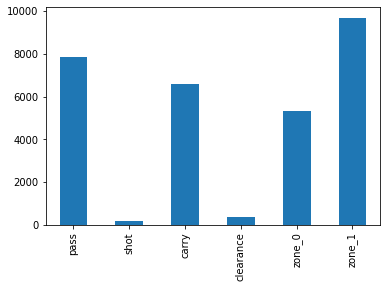

In [5]:
# bar chart of counts of first 4 columns in act_df
act_df.iloc[:].sum().plot.bar()

<AxesSubplot:>

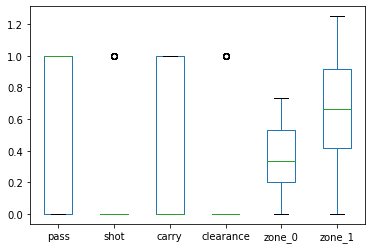

In [9]:
# boxplot of the last 2 columns of act_df
act_df.iloc[:].plot.box()